In [60]:
#!pip install requests
#!pip install bs4
#!pip install numpy
#!pip install pandas
#!pip3 install lxml
#!pip install matplotlib
#!pip install seaborn

import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
import sklearn
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier

# Here, we are using the PGA Tour's website for most of our statistics. They keep their data pretty clean, so 
# most of the tables won't need much preprocessing once we load them in. However, when we try to create a machine
# learning model, there will most likely be some extra work we need to do in order to account for missing values
# (since we will be using joins to combine the tables). The code here simply uses the requests API to get the 
# PGA tour page, and then we use BeautifulSoup to extract the HTML elements from it. We want the table, which has the
# id 'statsTable' (there is more than one table, the other one is not used for data, so it's easier to search by id). 
# Here we do a simply average of all the player's average scores during the 2019-2020 season. Typically, par is 72 strokes,
# so on average pros are doing almost 1 stroke better than par, or typically as it is written on a score card, -1. That's
# not bad, much better than the average golfer, which is universally defined as
# +18 over par, but not necessarily the case statistically
# (a harder course could have a much worse average score). However, it's not good enough to win tournaments. Let's see what
# the winning score in a tournament is. 

# CALCULATE AVERAGE PGA PRO SCORE

r = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.120.y2019.html')
bs = BeautifulSoup(r.text, 'html.parser')
table = bs.find(id = 'statsTable')
#print(table)
d = pd.read_html(table.prettify()) # data is pretty tidy, so not too much pre-processing to do
df = d[0]
avg_score = df['AVG'].mean()
#yr_lst = [2019 for i in range(len(df))]
#f = plt.figure(1)
#ax = sns.violinplot(x=yr_lst,y=df['AVG']).set(title="Average Score among all pros", xlabel='Year',ylabel='Strokes per round')
#plt.show()
print("average score among all pros: " + str(avg_score))
#print(df)

# CALCULATING WINNING TOURNAMENT SCORE




average score among all pros: 70.98463297872341


average gir among all pros: 66.64191489361703
         PLAYER NAME     AVG      %  EVENTS
0       Rory McIlroy  69.057  68.55    19.0
1    Patrick Cantlay  69.306  67.21    21.0
2       Webb Simpson  69.377  65.81    21.0
3      Brooks Koepka  69.395  69.97    21.0
4      Justin Thomas  69.466  70.68    20.0
..               ...     ...    ...     ...
180      Seth Reeves  72.156  66.83    25.0
181  Ted Potter, Jr.  72.214  66.35    23.0
183   Martin Trainer  72.343  60.47    25.0
184         Whee Kim  72.474  66.18    27.0
185        John Chin  72.485  68.72    21.0

[162 rows x 4 columns]
SLOPE: -0.4308256841906807


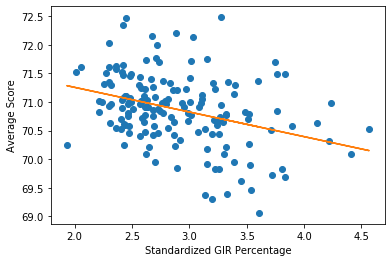

In [2]:
gir = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.103.y2019.html')
gir_bs = BeautifulSoup(gir.text, 'html.parser')
gir_table = gir_bs.find(id = 'statsTable')
#print(table)
gir_data = pd.read_html(gir_table.prettify()) # data is pretty tidy, so not too much pre-processing to do
gir_df = gir_data[0]

events = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.138.y2019.html')
events_bs = BeautifulSoup(events.text, 'html.parser')
events_table = events_bs.find(id = 'statsTable')
#print(table)
events_data = pd.read_html(events_table.prettify()) # data is pretty tidy, so not too much pre-processing to do
events_df = events_data[0]

#print(gir_df)
avg_gir = gir_df['%'].mean()
print("average gir among all pros: " + str(avg_gir))
#above_avg = gir_df[gir_df['%'] > avg_gir]
#print(above_avg)

avgscore_gir_df = df.merge(gir_df, how = 'right', left_on = 'PLAYER NAME', right_on = 'PLAYER NAME')
#print(avgscore_gir_df.columns)
avgscore_gir_df = avgscore_gir_df.drop(columns=['ROUNDS_x', 'TOTAL STROKES', 'TOTAL ADJUSTMENT', 'TOTAL ROUNDS',
                                          'ROUNDS_y', 'RELATIVE/PAR', 'RANK  THIS WEEK_x', 'RANK LAST WEEK_x',
                                         'GREENS HIT', '# HOLES', 'RANK LAST WEEK_y', 'RANK  THIS WEEK_y'])

avgscore_gir_events_df = avgscore_gir_df.merge(events_df, how = 'left', left_on = 'PLAYER NAME', right_on = 'PLAYER NAME')

avgscore_gir_events_df = avgscore_gir_events_df.drop(columns=['RANK  THIS WEEK', 'RANK LAST WEEK',
                                                             'TOP 10', '1ST', '2ND', '3RD'])
avgscore_gir_events_df =  avgscore_gir_events_df.dropna() # removing null cols

print(avgscore_gir_events_df)

f2 = plt.figure(2)
x = avgscore_gir_events_df['%']/avgscore_gir_events_df['EVENTS']
y = avgscore_gir_events_df['AVG']
plt.scatter(x, y)
plt.xlabel('Standardized GIR Percentage')
plt.ylabel('Average Score')


x = pd.to_numeric(x)
y = pd.to_numeric(y)
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')

print("SLOPE: " + str(m))
plt.show()


#print(main_df.to_string())
    

         PLAYER NAME     AVG      %  EVENTS  % MADE
0       Rory McIlroy  69.057  68.55    19.0   88.75
1    Patrick Cantlay  69.306  67.21    21.0   87.94
2       Webb Simpson  69.377  65.81    21.0   88.48
3      Brooks Koepka  69.395  69.97    21.0   88.69
4      Justin Thomas  69.466  70.68    20.0   87.05
..               ...     ...    ...     ...     ...
157      Seth Reeves  72.156  66.83    25.0   86.18
158  Ted Potter, Jr.  72.214  66.35    23.0   85.44
159   Martin Trainer  72.343  60.47    25.0   88.22
160         Whee Kim  72.474  66.18    27.0   88.95
161        John Chin  72.485  68.72    21.0   86.18

[162 rows x 5 columns]
SLOPE: -0.2893555939382997


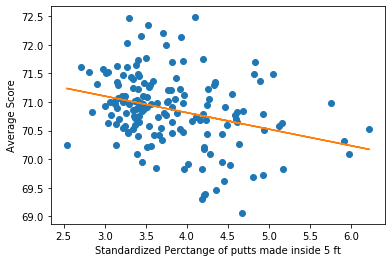

In [3]:
putts = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.484.y2019.eoff.t060.html') # putts inside 10 ft
putts_bs = BeautifulSoup(putts.text, 'html.parser')
putts_table = putts_bs.find(id = 'statsTable')
#print(table)
putts_data = pd.read_html(putts_table.prettify()) # data is pretty tidy, so not too much pre-processing to do
putts_df = putts_data[0]

main_putt_df = avgscore_gir_events_df.merge(putts_df, how = 'right', left_on = 'PLAYER NAME', right_on = 'PLAYER NAME')
#print(main_df.columns)
main_putt_df = main_putt_df.drop(columns = ['RANK  THIS WEEK', 'RANK LAST WEEK',
                              'ATTEMPTS', 'PUTTS MADE', 'ROUNDS'])

main_putt_df = main_putt_df.dropna()

print(main_putt_df)

f3 = plt.figure(3)
x2 = main_putt_df['% MADE']/main_putt_df['EVENTS']
y2 = main_putt_df['AVG']
plt.scatter(x2, y2)
plt.xlabel('Standardized Perctange of putts made inside 5 ft')
plt.ylabel('Average Score')


x2 = pd.to_numeric(x2)
y2 = pd.to_numeric(y2)
b2, m2 = polyfit(x2, y2, 1)
plt.plot(x2, y2, '.')
plt.plot(x2, b2 + m2 * x2, '-')
print("SLOPE: " + str(m2))
plt.show()

         PLAYER NAME     AVG    GIR  EVENTS  % MADE  FAIRWAYS
0       Rory McIlroy  69.057  68.55    19.0   88.75     61.82
1    Patrick Cantlay  69.306  67.21    21.0   87.94     57.34
2       Webb Simpson  69.377  65.81    21.0   88.48     66.82
3      Brooks Koepka  69.395  69.97    21.0   88.69     61.83
4      Justin Thomas  69.466  70.68    20.0   87.05     59.98
..               ...     ...    ...     ...     ...       ...
157      Seth Reeves  72.156  66.83    25.0   86.18     57.22
158  Ted Potter, Jr.  72.214  66.35    23.0   85.44     63.22
159   Martin Trainer  72.343  60.47    25.0   88.22     50.76
160         Whee Kim  72.474  66.18    27.0   88.95     62.07
161        John Chin  72.485  68.72    21.0   86.18     58.15

[162 rows x 6 columns]
SLOPE: -0.3893515507431466


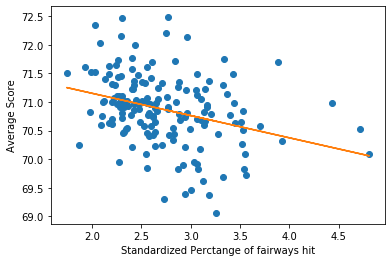

In [4]:
fairway = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.102.y2019.html') # driving accuracy, or fairway percentage
fairway_bs = BeautifulSoup(fairway.text, 'html.parser')
fairway_table = fairway_bs.find(id = 'statsTable')
#print(table)
fairway_data = pd.read_html(fairway_table.prettify()) # data is pretty tidy, so not too much pre-processing to do
fairway_df = fairway_data[0]

main_fairway_df = main_putt_df.merge(fairway_df, how = 'left', left_on = 'PLAYER NAME', right_on = 'PLAYER NAME')
main_fairway_df = main_fairway_df.rename(columns={"%_x": "GIR", "%_y": "FAIRWAYS"})
main_fairway_df = main_fairway_df.dropna()
#print(main_fairway_df.columns)
main_fairway_df = main_fairway_df.drop(columns=['RANK  THIS WEEK', 'RANK LAST WEEK', 'ROUNDS',
                                              'FAIRWAYS HIT','POSSIBLE FAIRWAYS'])

print(main_fairway_df)

f4 = plt.figure(4)
x3 = main_fairway_df['FAIRWAYS']/main_fairway_df['EVENTS']
y3 = main_fairway_df['AVG']
plt.scatter(x3, y3)
plt.xlabel('Standardized Perctange of fairways hit')
plt.ylabel('Average Score')


x3 = pd.to_numeric(x3)
y3 = pd.to_numeric(y3)
b3, m3 = polyfit(x3, y3, 1)
plt.plot(x3, y3, '.')
plt.plot(x3, b3 + m3 * x3, '-')
print("SLOPE: " + str(m3))
plt.show()


Index(['RANK  THIS WEEK', 'RANK LAST WEEK', 'PLAYER NAME', 'ROUNDS', 'AVG.',
       'TOTAL DISTANCE', 'TOTAL DRIVES'],
      dtype='object')
         PLAYER NAME     AVG    GIR  EVENTS  % MADE  FAIRWAYS  DISTANCE
0       Rory McIlroy  69.057  68.55    19.0   88.75     61.82     313.5
1    Patrick Cantlay  69.306  67.21    21.0   87.94     57.34     304.7
2       Webb Simpson  69.377  65.81    21.0   88.48     66.82     288.6
3      Brooks Koepka  69.395  69.97    21.0   88.69     61.83     309.0
4      Justin Thomas  69.466  70.68    20.0   87.05     59.98     302.2
..               ...     ...    ...     ...     ...       ...       ...
157      Seth Reeves  72.156  66.83    25.0   86.18     57.22     311.4
158  Ted Potter, Jr.  72.214  66.35    23.0   85.44     63.22     281.4
159   Martin Trainer  72.343  60.47    25.0   88.22     50.76     303.8
160         Whee Kim  72.474  66.18    27.0   88.95     62.07     284.3
161        John Chin  72.485  68.72    21.0   86.18     58.15     3

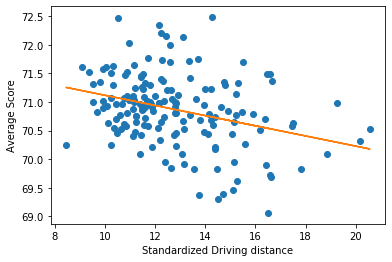

In [5]:
# THIS IS THE STATISTICS WE BELIEVE TO NOT BE THAT GOOD
distance = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.101.y2019.html') # driving distance
distance_bs = BeautifulSoup(distance.text, 'html.parser')
distance_table = distance_bs.find(id = 'statsTable')
#print(table)
distance_data = pd.read_html(distance_table.prettify()) # data is pretty tidy, so not too much pre-processing to do
distance_df = distance_data[0]
print(distance_df.columns)
distance_df = distance_df.rename(columns={"AVG." : "DISTANCE"})

#print(distance_df)

main_df = main_fairway_df.merge(distance_df, how = 'left', left_on = 'PLAYER NAME', right_on = 'PLAYER NAME')
main_df = main_df.drop(columns=['RANK  THIS WEEK', 'RANK LAST WEEK','ROUNDS','TOTAL DISTANCE', 'TOTAL DRIVES']) 
# no NAN entries so no need to drop anything

print(main_df)

f5 = plt.figure(5)
x4 = main_df['DISTANCE']/main_df['EVENTS']
y4 = main_df['AVG']
plt.scatter(x4, y4)
plt.xlabel('Standardized Driving distance')
plt.ylabel('Average Score')


x4 = pd.to_numeric(x4)
y4 = pd.to_numeric(y4)
b4, m4 = polyfit(x4, y4, 1)
plt.plot(x4, y4, '.')
plt.plot(x4, b4 + m4 * x4, '-')
print("SLOPE: " + str(m4))
plt.show()


In [6]:
# finding correlation coefficients
print(main_df.corr()) # look at AVG column for correlation coefficients

               AVG       GIR    EVENTS    % MADE  FAIRWAYS  DISTANCE
AVG       1.000000 -0.332953  0.280590 -0.279341 -0.156842 -0.244312
GIR      -0.332953  1.000000  0.033214 -0.152749  0.255043  0.218694
EVENTS    0.280590  0.033214  1.000000  0.085697  0.068606 -0.072485
% MADE   -0.279341 -0.152749  0.085697  1.000000  0.189360 -0.210839
FAIRWAYS -0.156842  0.255043  0.068606  0.189360  1.000000 -0.634074
DISTANCE -0.244312  0.218694 -0.072485 -0.210839 -0.634074  1.000000


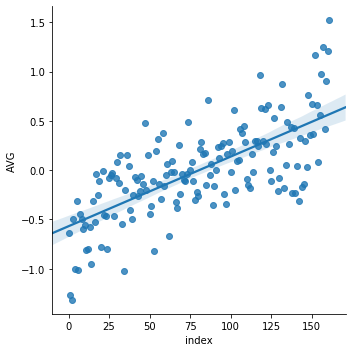

In [107]:
# Linear regression model for predicting a golf player's average score
# Features used for prediction: Greens in Regulation, Numver of Events, Percentage of Putts Made, Fairways Made, Driving Distance Made
features_df = main_df.drop(columns = ['PLAYER NAME', 'AVG'])
# Target of prediction: Average Score
target_df = main_df.drop(columns = ['PLAYER NAME', 'GIR', 'EVENTS', '% MADE', 'FAIRWAYS', 'DISTANCE'])

# Training Data
X = features_df
y = target_df['AVG']

# Fit Linear Regression Model
lm = linear_model.LinearRegression()
lm = lm.fit(X, y)

# Scatter Plot for Residual Analysis (Linear Regression Model)
'''The scatter plot indicates a positive slope which is indicative a linear regression model that can be rather improved.
In other words, the linear regression model residuals should be as close to 0 as possible with a slope as close to 0 to 
show a model that effectively predicts average scores.'''
lm_predictions = lm.predict(X)
residuals = main_df['AVG'] - lm_predictions
residuals_df = pd.DataFrame(residuals).reset_index()
sns.lmplot(x = 'index', y = 'AVG', data = residuals_df, fit_reg = True)

In [63]:
# Print Statistical Summary for Linear Regression Model Fit
model_x = sm.add_constant(X)
model = sm.OLS(y, model_x)
model_statistics = model.fit()
print(model_statistics.summary())
'''The R-squared value for the linear regression model is 0.433. This indicates that 43.4% of the variation in average golf score can
be attributed to that of the independent variables: Greens in Regulation, Numver of Events, Percentage of Putts Made, Fairways Made, Driving Distance Made.'''

                            OLS Regression Results                            
Dep. Variable:                    AVG   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     23.86
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           8.88e-18
Time:                        18:22:44   Log-Likelihood:                -107.35
No. Observations:                 162   AIC:                             226.7
Df Residuals:                     156   BIC:                             245.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.6488      3.804     27.512      0.0

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

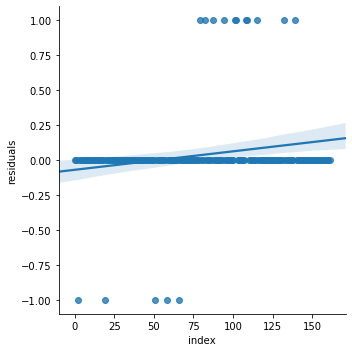

In [103]:
'''After analyzing the various correlation coefficients between average golf scores and predictive features,
greens in regulation vs. average golf score conveys the highest correlation coefficient (-0.333). This suggests
that the relationships between greens in regulation and average golf score is a rather moderately strong and 
negative correlation. Since lower golf scores are favored, creating a random forest model of this relationship
seems reasonable and useful for aiding an aspiring golf professional.'''
# Random forest model to determine if a player's average score is greater than the Pro Golfer Average for 2019 given the player's greens in regulation
# Reformatting of average score into appropriate dimensions and a binary classification dependent on whether the value > pro golfer average
avg_score_df = pd.DataFrame(main_df['AVG']).as_matrix().flatten()
avg_score_df = np.array([1 if x >= main_df['AVG'].mean() else 0 for x in avg_score_df]).reshape(-1, 1)

# Reformatting of greens in regulation column
gir_df = pd.DataFrame(main_df['GIR']).as_matrix().flatten().reshape(-1, 1)

# Fit Random Forest Model
random_forest = RandomForestClassifier(n_jobs = -1).fit(gir_df, avg_score_df)
random_forest_statistics = sklearn.model_selection.cross_val_score(random_forest, gir_df, avg_score_df, cv = 10)

# Use random forest model to predict whether player's average score will be greater or less than the 2019 Pro Golfer Average
# Format both prediction data and ground truth for residual analysis
rf_predictions = random_forest.predict(gir_df)
rf_predictions_df = pd.DataFrame(rf_predictions, columns = ['rf_predict'])
avg_score_predictions_df = pd.DataFrame(avg_score_df.flatten(), columns = ['avg_score_predict'])

# Scatter Plot for Residual Analysis (Random Forest Model)
'''The scatter plot indicates a slope that approaches that of 0. This suggests that the random forest model
provides a great representation for predicting whether a player's average score is greater than the 2019 Pro Golfer Average
because the vast majority of residual points surround 0 (meaning that predictions match ground truth values).'''
rf_residuals = avg_score_predictions_df['avg_score_predict'] - rf_predictions_df['rf_predict']
rf_residuals_df = pd.DataFrame(rf_residuals, columns = ['residuals']).reset_index()
sns.lmplot(x = 'index', y = 'residuals', data = rf_residuals_df, fit_reg = True)

In [108]:
# Function to predict average score using linear regression model
def predict_avg_score_linear(gir, num_events, percent_made, fairways_made, driving_distance):
    features_df = pd.DataFrame([[gir, num_events, percent_made, fairways_made, driving_distance]], columns = ['GIR', 'EVENTS', '% MADE', 'FAIRWAYS', 'DISTANCE'])
    predictions = lm.predict(features_df)
    
    return "Average score is predicted to be " + str(predictions[0])

print("Linear Regression Model: " + predict_avg_score_linear(68.55, 19.0, 88.75, 61.82, 313.5)) # Prediction using Rory McIlroy performance data

# Function to predict whether a player's average score is greater than the Pro Golfer Average for 2019 given the player's greens in regulation
def predict_avg_score_random_forest(gir):
    features_df = pd.DataFrame([[gir]], columns = ['GIR'])
    predictions = random_forest.predict(features_df)
    
    if (predictions[0] == 0):
        return "Average score is predicted to be below that of the average pro golf player (< 70.985)"
    else:
        return "Average score is predicted to be above that of the average pro golf player (> 70.985)"

print("Random Forest Classification: " + str(predict_avg_score_random_forest(68.55))) # Prediction using Rory McIlroy performance data
'''Rory McIlroy's true average score for the 2019 PGA Season was 69.057. Both the linear regression model and the 
random forest model are successful in predicting an average score of 69.695 and an average score that is below that
of the average pro golf player (less than 70.985) respectively.'''

Linear Regression Model: Average score is predicted to be 69.69546291331173
Random Forest Classification: Average score is predicted to be below that of the average pro golf player (< 70.985)


"Rory McIlroy's true average score for the 2019 PGA Season was 69.057. Both the linear regression model and the \nrandom forest model are successful in predicting an average score of 69.695 and an average score that is below that\nof the average pro golf player (less than 70.985) respectively."